In [2]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
from skimage.transform import rescale, resize, downscale_local_mean
import random

In [3]:
# Download datasets
! pip install -q kaggle
! mkdir ~ /.kaggle
! cp kaggle.json ~ /.kaggle /
! chmod 600 ~ /.kaggle / kaggle.json
! kaggle datasets download 'alxmamaev/flowers-recognition'
! mkdir -p flowers_recognition
! unzip flowers-recognition.zip -d flowers_recognition

100%|████████████████████████████████████████| 450M/450M [05:24<00:00, 2.07MB/s]
100%|████████████████████████████████████████| 450M/450M [05:24<00:00, 1.45MB/s]
Archive:  flowers-recognition.zip
  inflating: flowers_recognition/flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers_recognition/flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers_recognition/flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers_recognition/flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers_recognition/flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers_recognition/flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers_recognition/flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers_recognition/flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers_recognition/flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers_recognition/flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers_recognition/flow

In [10]:
debug = True

def create_dataset(path, arr, label):
    global debug
    arr = []
    for fil in os.listdir(path):
        link = path + fil
        if link[-3:] == 'pyc' or link[-2:] == 'py':
            continue
        img = mpimg.imread(link)
        img = rgb2gray(img)
        if debug:
            plt.imshow(img, cmap=plt.get_cmap('gray'), vmin=np.min(img), vmax=np.max(img))
            plt.show()
            debug = False
        img = resize(img, (320, 240, 1), anti_aliasing=True)
        img = img.reshape(320 * 240)
        arr.append({
            'features': np.array(img),
            'label': label
        })

    debug = True
    return arr


def rgb2gray(rgb):
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

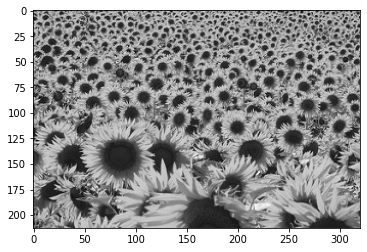

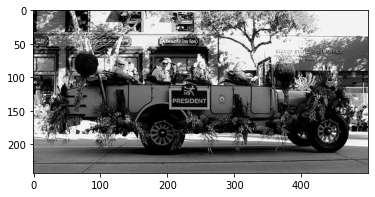

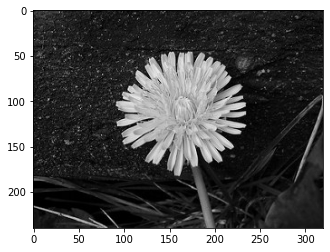

In [11]:
# Import datasets
dataset_path = "./flowers_recognition/flowers/"
datasets = []

sunflower = []
sunflower = create_dataset(dataset_path + 'sunflower/', sunflower, 0)
datasets += sunflower[:100]

rose = []
rose = create_dataset(dataset_path + 'rose/', rose, 1)
datasets += rose[:100]

dandelion = []
dandelion = create_dataset(dataset_path + 'dandelion/', dandelion, 2)
datasets += dandelion[:100]

In [38]:
def split_data(train_ratio=0.8):
    # Split train and test

    random.shuffle(datasets)
    counter = [0, 0, 0]
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    for data in datasets:
        if counter[data['label']] < len(datasets) / 3 * train_ratio:
            X_train.append(data['features'])
            Y_train.append(data['label'])
        else:
            X_test.append(data['features'])
            Y_test.append(data['label'])
        counter[data['label']] += 1
    return np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test)

def one_hot_encode(data):
    one_hot = np.zeros((data.shape[0], 3))
    one_hot[np.arange(data.shape[0]), data] = 1
    return one_hot


def normalize(data):
    return data / 255.0


def preprocess(X, y):
    X = normalize(X)
    X = X.reshape(-1, 76800, 1)
    y = one_hot_encode(y)
    y = y.reshape(-1, 3, 1)
    return X, y


def sigmoid(out):
    return 1.0 / (1.0 + np.exp(-out))


def delta_sigmoid(out):
    return sigmoid(out) * (1 - sigmoid(out))


def SigmoidCrossEntropyLoss(a, y):
    return np.sum(np.nan_to_num(-y * np.log(a) - (1 - y) * np.log(1 - a)))

In [37]:
class DNN(object):
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        # setting appropriate dimensions for weights and biases
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, x):
        activation = x
        activations = [x]  # list to store activations for every layer
        outs = []  # list to store out vectors for every layer
        for b, w in zip(self.biases, self.weights):
            out = np.dot(w, activation) + b
            outs.append(out)
            activation = sigmoid(out)
            activations.append(activation)
        return outs, activations

    def get_batch(self, X, y, batch_size):
        for batch_idx in range(0, X.shape[0], batch_size):
            batch = zip(X[batch_idx:batch_idx + batch_size],
                        y[batch_idx:batch_idx + batch_size])
            yield batch

    def train(self, X, y, batch_size=100, learning_rate=0.2, epochs=1000):
        loss_hist = []
        acc_hist = []
        n_batches = int(X.shape[0] / batch_size)
        for j in range(epochs):
            batch_iter = self.get_batch(X, y, batch_size)
            for i in range(n_batches):
                batch = next(batch_iter)
                # same shape as self.biases
                del_b = [np.zeros(b.shape) for b in self.biases]
                # same shape as self.weights
                del_w = [np.zeros(w.shape) for w in self.weights]
                for batch_X, batch_y in batch:
                    # accumulate all the bias and weight gradients
                    loss, delta_del_b, delta_del_w = self.backpropagate(
                        batch_X, batch_y)
                    del_b = [db + ddb for db, ddb in zip(del_b, delta_del_b)]
                    del_w = [dw + ddw for dw, ddw in zip(del_w, delta_del_w)]
            # update weight and biases by multiplying ratio learning rate and batch_size
            # multiplied with the accumulated gradients(partial derivatives)
            # calculate change in weight(delta) and biases and update weight
            # with the changes
            self.weights = [w - (learning_rate / batch_size)
                            * delw for w, delw in zip(self.weights, del_w)]
            self.biases = [b - (learning_rate / batch_size)
                           * delb for b, delb in zip(self.biases, del_b)]
            print("\nEpoch %d complete\n" % j)
            print("Loss: ", loss)
            loss_hist.append(loss)
            acc_hist.append(self.eval(X, y))
        print("\n ****Training Complete**** \n")
        return loss_hist, acc_hist

    def backpropagate(self, x, y):
        del_b = [np.zeros(b.shape) for b in self.biases]
        del_w = [np.zeros(w.shape) for w in self.weights]

        # for calculating the current loss or cost forward pass through the neural net once
        # outs and activations are lists to store activations and out vector
        # for every layer
        outs, activations = self.feedforward(x)
        #Cost function:
        loss = SigmoidCrossEntropyLoss(activations[-1], y)
        # calculate derivative of cost Sigmoid Cross entropy which is to be minimized
        delta_cost = activations[-1] - y
        # backward pass to reduce cost
        # gradients at output layers
        delta = delta_cost
        del_b[-1] = delta
        del_w[-1] = np.dot(delta, activations[-2].T)

        # updating gradients of each layer using reverse or negative indexing, by propagating
        # gradients of previous layers to current layer so that gradients of weights and biases
        # at each layer can be calculated
        for l in range(2, self.num_layers):
            out = outs[-l]
            delta_activation = delta_sigmoid(out)
            delta = np.dot(self.weights[-l + 1].T, delta) * delta_activation
            del_b[-l] = delta
            del_w[-l] = np.dot(delta, activations[-l - 1].T)
        return (loss, del_b, del_w)

    def eval(self, X, y):
        count = 0
        for x, _y in zip(X, y):
            outs, activations = self.feedforward(x)
            # postion of maximum value is the predicted label
            if np.argmax(activations[-1]) == np.argmax(_y):
                count += 1
        acc = (float(count) / X.shape[0]) * 100
        print("Accuracy: ", acc)
        return acc

In [40]:
X_train, Y_train, X_test, Y_test = split_data(train_ratio=0.8)

X_train, Y_train = preprocess(X_train, Y_train)
X_test, Y_test = preprocess(X_test, Y_test)
# 320*240*1=76800, height and width of an image in the dataset is 320x240 and 1 is for B/W(gray) channel
# [76800, 10, 3] implies a neural network with 1 input layer of size 76800, 1 hidden
# layers of size 10 and a output layer of size 3, hence 3
# layers(including input layer), more layers can be added to the list for increasing layers
model = DNN([76800, 10, 3])  # initialize the model

loss_hist, acc_hist = model.train(X_train, Y_train, epochs=50)  # train the model
model.eval(X_test, Y_test)  # check accuracy using validation set


Epoch 0 complete

Loss:  1.0157740783074933
Accuracy:  32.083333333333336

Epoch 1 complete

Loss:  1.034306345575957
Accuracy:  32.916666666666664

Epoch 2 complete

Loss:  1.0865882815860184
Accuracy:  30.833333333333336

Epoch 3 complete

Loss:  1.1378289163068729
Accuracy:  31.25

Epoch 4 complete

Loss:  1.209855516464803
Accuracy:  32.083333333333336

Epoch 5 complete

Loss:  1.280759802319417
Accuracy:  31.666666666666664

Epoch 6 complete

Loss:  1.343918062038151
Accuracy:  31.666666666666664

Epoch 7 complete

Loss:  1.3995356337858
Accuracy:  31.666666666666664

Epoch 8 complete

Loss:  1.4454053718291786
Accuracy:  31.666666666666664

Epoch 9 complete

Loss:  1.483175332440305
Accuracy:  32.083333333333336

Epoch 10 complete

Loss:  1.5144172319732663
Accuracy:  24.583333333333332

Epoch 11 complete

Loss:  1.5407766508401766
Accuracy:  25.416666666666664

Epoch 12 complete

Loss:  1.5639050475100986
Accuracy:  25.0

Epoch 13 complete

Loss:  1.58267666727075
Accuracy:  25

38.333333333333336

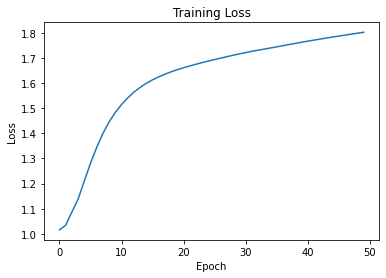

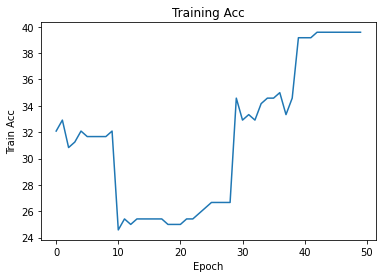

In [42]:
plt.plot(np.arange(len(loss_hist)), loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

plt.plot(np.arange(len(acc_hist)), acc_hist)
plt.xlabel("Epoch")
plt.ylabel("Train Acc")
plt.title("Training Acc")
plt.show()